## Imports, settings, & constants

In [1]:
from utils import *
from matplotlib.ticker import MultipleLocator
import vice
from vice.yields.presets import JW20
import dill
import math

# Plot settings
plt.rcParams.update({
    'xtick.direction': 'in',
    'xtick.top': True,
    'ytick.direction': 'in',
    'ytick.right': True,
    'figure.dpi': 140,
    'figure.figsize': (4, 4),
    'font.family': 'STIXgeneral',
    'mathtext.fontset': 'cm',
})

# Constants
METALLICITY_GRADIENT = -0.06 # dex/kpc
RECYCLING = 0.4
# Stellar mass of Milky Way (Licquia & Newman 2015, ApJ, 806, 96)
M_STAR_MW = 5.17e10

In [2]:
# Import data
data_dir = '/mnt/c/Users/dubay.11/OneDrive - The Ohio State University/Documents/Docs/First Year Project/Data'
# data_dir = '~/Documents/Data'
data = pd.read_csv(Path(data_dir) / 'dr17_cut_data.csv')
data

,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,APOKASC2_AGE,APOKASC2_AGE_PERR,APOKASC2_AGE_MERR,APOKASC2_AV,APOKASC2_AV_ERR,APOKASC2_NOTE,APOK2_MASS,APOK2_MASS_ERR,APOK2_RADIUS,APOK2_RADIUS_ERR
0,2M00000002+7417074,apo25m,120+12,none,0.000103,74.285408,119.401807,11.767414,8.597,0.039,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
1,2M00000035-7323394,lco25m,SMC12,none,0.001467,-73.394287,307.939441,-43.230305,15.008,0.045,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
2,2M00000068+5710233,apo25m,N7789,none,0.002850,57.173164,115.977154,-5.002392,10.664,0.023,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
3,2M00000133+5721163,apo25m,NGC7789_btx,none,0.005558,57.354549,116.014776,-4.824917,13.261,0.029,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
4,2M00000211+6327470,apo25m,117+01,none,0.008802,63.463078,117.227985,1.162167,11.880,0.024,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387942,2M23595837+5700444,apo25m,N7789,none,359.993224,57.012356,115.939899,-5.158948,12.657,0.026,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
387943,2M23595867-7339039,lco25m,SMC12,none,359.994493,-73.651093,307.846602,-42.982597,15.671,0.069,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
387944,2M23595886+5726058,apo25m,116-04,none,359.995265,57.434956,116.025359,-4.745011,11.466,0.024,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
387945,2M23595921+5609479,apo25m,NGC7789_MGA,none,359.996744,56.163330,115.771964,-5.991363,11.985,0.023,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN


## Plotting functions

In [3]:
def multi_zone_plot(vice_names, x, y, data_source='astroNN', zones=[4, 8, 12], xlim=None, ylim=None, 
                    lookback_offset=-2.5, nrows=1, title='', width=10, fmt=[], labels=[], legend_title=None):
    """
    Plot VICE simulation against data for multiple radial zones.
    
    Parameters
    ----------
    vice_names : str
        Name(s) of multizone VICE output directory(ies).
    x : str
        Parameter to plot on x-axis. Must be 'age' or '[fe/h]'.
    y : str
        Parameter to plot on y-axis. Must be '[fe/h]' or '[o/fe]'.
    data_source : str, optional [default : 'astroNN']
        Source for abundance data (age will always be from astroNN). Must be 'astroNN' or 'ASPCAP'.
    zones : array-like, optional [default : [4, 8, 12]]
        List of radial zones to plot.
    xlim : tuple, optional [default : None]
        Shared x-axis bounds for all panels. If None, default values will be chosen according
        to the x parameter.
    ylim : tuple, optional [default : None]
        Shared y-axis bounds for all panels. If None, default values will be chosen according
        to the y parameter.
    lookback_offset : float, optional [default : -2.5]
        Offset for VICE lookback times in Gyr. Adjust so that simulation and data timescales align.
    nrows : int, optional [default : 1]
        Number of rows of axes.
    title : str, optional [default : '']
        Figure title.
    width : float, optional [default : 10]
        Width of figure in inches.
    fmt : list, optional [default : []]
        Plot formatting for VICE outputs. If empty or incomplete, the default matplotlib formatting is used.
    labels : list, optional [default : []]
        Labels of VICE outputs to show in legend. If empty, defaults to the entries in vice_names.
    legend_title : str or None, optional
        Title for legend. Default is None, for no title.  
    
    """
    # Figure dimensions
    n = len(zones)
    ncols = int(np.ceil(n/nrows))
    height = 1.25 * (nrows / ncols) * width
    fig, axs = plt.subplots(nrows, ncols, figsize=(width, height), 
                            sharex=True, sharey=True, tight_layout=True)
    # Set data sources and settings for x-axis
    if x == 'age':
        xdatacol = 'ASTRONN_AGE'
        xvicecol = 'lookback'
        if xlim is None:
            xlim = (-1, 13)
        xlabel = 'astroNN age [Gyr]'
        x_major_locator = 5
        x_minor_locator = 1
    elif x == 'met':
        if data_source == 'astroNN':
            xdatacol = 'ASTRONN_FE_H'
            xlabel = 'astroNN [Fe/H]'
        elif data_source == 'ASPCAP':
            xdatacol = 'M_H'
            xlabel = 'ASPCAP [M/H]'
        xvicecol = '[fe/h]'
        if xlim is None:
            xlim = (-2.1, 0.6)
        x_major_locator = 0.5
        x_minor_locator = 0.1
    # Set data source and settings for y-axis
    if y == 'met':
        if data_source == 'astroNN':
            ydatacol = 'ASTRONN_FE_H'
            ylabel = 'astroNN [Fe/H]'
        elif data_source == 'ASPCAP':
            ydatacol = 'M_H'
            ylabel = 'ASPCAP [M/H]'
        yvicecol = '[fe/h]'
        if ylim is None:
            ylim = (-2.1, 0.6)
        y_major_locator = 0.5
        y_minor_locator = 0.1
    elif y == 'alpha':
        if data_source == 'astroNN':
            ydatacol = 'ASTRONN_O_FE'
            ylabel = 'astroNN [O/Fe]'
        elif data_source == 'ASPCAP':
            ydatacol = 'ALPHA_M'
            ylabel = r'ASPCAP [$\alpha$/Fe]'
        yvicecol = '[o/fe]'
        if ylim is None:
            ylim = (-0.2, 0.5)
        y_major_locator = 0.2
        y_minor_locator = 0.05
    
    # Convert VICE output name to list if only one provided
    if type(vice_names) == str:
        vice_names = [vice_names]
    # Append default formatting if provided list is insufficient
    if len(fmt) < len(vice_names):
        fmt += ['' for i in range(len(vice_names) - len(fmt))]
    # Use VICE directory names as legend labels if provided list is insufficient
    if len(labels) != len(vice_names):
        labels = vice_names
    # Import VICE output(s)
    outputs = [vice.output('milkyway/' + vice_name) for vice_name in vice_names]
    # Horizontal offset for VICE results
    lookback_offset = min(lookback_offset, -1)
    vice_end = int(lookback_offset * 100)    
    
    # Plot data in each zone
    for i, z in enumerate(zones):
        # Select axis
        row = int(i/ncols)
        col = i % ncols
        if nrows > 1:
            ax = axs[row, col]
        else:
            ax = axs[col]
        # Plot data within radial zone
        data_zone = data[(data['ASTRONN_GALR'] >= z) & (data['ASTRONN_GALR'] < z+1)]
        scatter_hist(ax, data_zone[xdatacol], data_zone[ydatacol], xlim=xlim, ylim=ylim)
        # Plot VICE output within zone
        for i, out in enumerate(outputs):
            vice_hist = out.zones['zone%s' % z].history
            xvicearr = np.array(vice_hist[xvicecol][:vice_end])
            if xvicecol == 'lookback':
                xvicearr += lookback_offset
            ax.plot(xvicearr, vice_hist[yvicecol][:vice_end], fmt[i], label=labels[i])
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        # Set axis tick locators
        ax.xaxis.set_major_locator(MultipleLocator(x_major_locator))
        ax.xaxis.set_minor_locator(MultipleLocator(x_minor_locator))
        ax.yaxis.set_major_locator(MultipleLocator(y_major_locator))
        ax.yaxis.set_minor_locator(MultipleLocator(y_minor_locator))
        # Axis labels on outside of grid only
        if row == nrows - 1:
            ax.set_xlabel(xlabel)
        if col == 0:
            ax.set_ylabel(ylabel)
        ax.set_title(r'%s$\leq R <$%s kpc' % (z, z+1))

    if len(vice_names) > 1:
        handles, labels = ax.get_legend_handles_labels()
        if nrows > 1:
            ax = axs[0, 0]
        else:
            ax = axs[0]
        ax.legend(handles, labels, title=legend_title)
    fig.suptitle(title)
    plt.show()

In [18]:
def single_zone_plot(vice_names, zone, tlim=(-1, 13), felim=(-2.1, 0.6), olim=(-0.2, 0.5), 
                     data_source='astroNN', lookback_offset=-2.5, title='', width=10, fmt=[], 
                     labels=[], legend_title=None, save=''):
    """
    Plot [Fe/H] vs age, [O/Fe] vs age, and [O/Fe] vs [Fe/H] for a single radial zone.
    
    Parameters
    ----------
    vice_names : list
        Name of VICE output directory or directories.
    zone : int
        Index of radial zone.
    tlim : tuple, optional
        Plot bounds for age or lookback time in Gyr. Default is (-1, 13).
    felim : tuple, optional
        Plot bounds for [Fe/H]. Default is (-2.1, 0.6).
    olim : tuple, optional
        Plot bounds for [O/Fe]. Default is (-0.2, 0.5).
    data_source : str, optional [default : 'astroNN']
        Source for abundance data (age will always be from astroNN). Must be 'astroNN' or 'ASPCAP'.
    lookback_offset : float, optional [default : -2.5]
        Offset for VICE lookback times in Gyr. Adjust so that simulation and data timescales align.
    title : str, optional [default : '']
        Figure title.
    width : float, optional [default : 12]
        Width of figure in inches.
    fmt : list, optional [default : []]
        Plot formatting for VICE outputs. If empty or incomplete, the default matplotlib formatting is used.
    labels : list, optional [default : []]
        Labels of VICE outputs to show in legend. If empty, defaults to the entries in vice_names.
    legend_title : str or None, optional
        Title for legend. Default is None, for no title.
    save : str, optional
        Filename to save figure. If '', won't save.
    
    """
    fig, axs = plt.subplots(1, 3, figsize=(width, width/2.75), constrained_layout=True)
    
    # Data column names depending on data source
    if data_source == 'astroNN':
        fe_data_col = 'ASTRONN_FE_H'
        fe_ax_label = 'astroNN [Fe/H]'
        o_data_col = 'ASTRONN_O_FE'
        o_ax_label = 'astroNN [O/Fe]'
    elif data_source == 'ASPCAP':
        fe_data_col = 'M_H'
        fe_ax_label = 'ASPCAP [M/H]'
        o_data_col = 'ALPHA_M'
        o_ax_label = r'ASPCAP [$\alpha$/M]'
        
    # Limit data within radial zone
    data_zone = data[(data['ASTRONN_GALR'] >= zone) & (data['ASTRONN_GALR'] < zone+1)]
    # Horizontal offset for VICE results
    lookback_offset = min(lookback_offset, -1)
    vice_end = int(lookback_offset * 100)
    
    # Convert VICE output name to list if only one provided
    if type(vice_names) == str:
        vice_names = [vice_names]
    # Append default formatting if provided list is insufficient
    if len(fmt) < len(vice_names):
        fmt += ['' for i in range(len(vice_names) - len(fmt))]
    # Use VICE directory names as legend labels if provided list is insufficient
    if len(labels) != len(vice_names):
        labels = vice_names
    # Plot VICE outputs
    for i, vice_name in enumerate(vice_names):
        out = vice.output('milkyway/' + vice_name)
        vice_hist = out.zones['zone%s' % zone].history
        axs[0].plot(np.array(vice_hist['lookback'][:vice_end]) + lookback_offset, 
                vice_hist['[fe/h]'][:vice_end], fmt[i], label=labels[i])
        axs[1].plot(np.array(vice_hist['lookback'][:vice_end]) + lookback_offset, 
                vice_hist['[o/fe]'][:vice_end], fmt[i])
        axs[2].plot(vice_hist['[fe/h]'][:vice_end], vice_hist['[o/fe]'][:vice_end], fmt[i])
    
    # First panel: metallicity vs time
    ax = axs[0]
    scatter_hist(ax, data_zone['ASTRONN_AGE'], data_zone[fe_data_col], xlim=tlim, ylim=felim)
    ax.set_xlim(tlim)
    ax.set_ylim(felim)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.set_xlabel('astroNN age [Gyr]')
    ax.set_ylabel(fe_ax_label)

    # Second panel: alpha vs time
    ax = axs[1]
    scatter_hist(ax, data_zone['ASTRONN_AGE'], data_zone[o_data_col], xlim=tlim, ylim=olim)
    ax.set_xlim(tlim)
    ax.set_ylim(olim)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.set_xlabel('astroNN age [Gyr]')
    ax.set_ylabel(o_ax_label)

    # Third panel: alpha vs fe
    ax = axs[2]
    scatter_hist(ax, data_zone[fe_data_col], data_zone[o_data_col], xlim=felim, ylim=olim)
    ax.set_xlim(felim)
    ax.set_ylim(olim)
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.set_xlabel(fe_ax_label)
    ax.set_ylabel(o_ax_label)
    
    if len(vice_names) > 1:
        axs[0].legend(title=legend_title, loc='lower left')
    if title == '':
        title = r'$%s \leq R < %s$ kpc' % (zone, zone+1)
    fig.suptitle(title)
    
    if len(save) > 0:
        plt.savefig(save)
    plt.show()

## Mass-loading factor & metallicity gradient

The mass-loading factor $\eta$ as a function of galactic radius depends on the radial metallicity gradient. The default gradient of $-0.08$ dex/kpc results in [Fe/H] outputs at large radii which are too low compared to the astroNN dataset, so we instead adopt a shallower gradient of $-0.06$ dex/kpc.

In [7]:
# Star formation history functions
def g(rgal, rthin=2.5, rthick=2, sigma_ratio0=0.27):
    """
    Stellar surface density gradient as function of galactic radius.
    rgal : galactic radius in kpc
    rthin : scale radius of thin disc in kpc
    rthick : scale radius of thick disc in kpc
    sigma_ratio0 : ratio of thick / thin surface densities at rgal=0
    """
    return np.exp(-rgal/rthin) + sigma_ratio0 * np.exp(-rgal/rthick)

def f_c(t):
    """
    Constant star formation history as a function of time.
    """
    return 1

def f_io(t, tau_rise=2, tau_sfh=15):
    """
    Inside-out star formation history as a function of time.
    t : time in Gyr
    tau_rise : rise timescale in Gyr
    tau_sfh : star formation history timescale in Gyr
    """
    return (1 - np.exp(-t/tau_rise)) * np.exp(-t/tau_sfh)

def f_lb(t, Ab=1.5, tb=10.5, sigma_b=1, **kwargs):
    """
    Inside-out star formation history modified to include a late burst.
    t : time in Gyr
    Ab : dimensionless strength of starburst
    tb : time of local maximum in SFH during burst in Gyr
    sigma_b : width of Gaussian describing burst in Gyr
    """
    burst = Ab * np.exp(-(t-tb)**2/(2*sigma_b**2))
    return f_io(t, **kwargs) * (1 + burst)

def normalize(func, dt=0.01, dr=1, recycling=RECYCLING, tmax=12.5, rmax=15.5):
    """
    Compute normalization pre-factor for star formation function.
    """
    time_integral = 0
    for i in range(int(tmax / dt)):
        time_integral += func(i * dt) * dt * 1.e9 # yr to Gyr

    radial_integral = 0
    for i in range(int(rmax / dr)):
        radial_integral += g(dr * (i + 0.5)) * math.pi * (
            (dr * (i + 1))**2 - (dr * i)**2
        )

    return M_STAR_MW / ((1 - recycling) * radial_integral * time_integral)

A_c = normalize(f_c)
A_io = normalize(f_io)
A_lb = normalize(f_lb)

def constant_sfh(t, rgal):
    return A_c * f_c(t) * g(rgal)

def inside_out(t, rgal):
    return A_io * f_io(t) * g(rgal)

def late_burst(t, rgal):
    return A_lb * f_lb(t) * g(rgal)

In [8]:
# Grab VICE CCSN yield & solar metallicity settings
ycc_o = vice.yields.ccsne.settings['o']
z_solar_o = vice.solar_z['o']

def eta(rgal, gradient=METALLICITY_GRADIENT, mode4=0.3, recycling=0.4):
    """
    Mass-loading factor as function of galactic radius in kpc.
    mode4 : mode of stellar [alpha/H] at 4 kpc radius
    """
    # Set [alpha/H] at 8 kpc to be 0
    exp = -gradient * (rgal - 4) - mode4
    return (ycc_o / z_solar_o) * 10 ** exp + recycling - 1

# Power-law DTD with different mass-loading functions
# Uses default (constant) evolution function
simtime = np.linspace(0, 12.5, 1251)
hds = vice.toolkit.hydrodisk.hydrodiskstars(np.linspace(0, 20, 21), N=2e5, mode='diffusion')

mw = vice.milkyway(name='milkyway/shallow_eta', N=2e5, zone_width=1.0)
mw.mass_loading = lambda r: eta(r, gradient=-0.06)
mw.migration.stars = hds
mw.delay = 0.04 # Gyr
mw.RIa = 'plaw'
mw.mode = 'sfr'
mw.evolution = constant_sfh
mw.dt = 0.01
mw.run(simtime, overwrite=True)

mw = vice.milkyway(name='milkyway/middling_eta', N=2e5, zone_width=1.0)
mw.mass_loading = lambda r: eta(r, gradient=-0.08)
mw.migration.stars = hds
mw.delay = 0.04 # Gyr
mw.RIa = 'plaw'
mw.mode = 'sfr'
mw.evolution = constant_sfh
mw.dt = 0.01
mw.run(simtime, overwrite=True)

mw = vice.milkyway(name='milkyway/steep_eta', N=2e5, zone_width=1.0)
# slightly adjust mode at 4 kpc to keep eta positive
mw.mass_loading = lambda r: eta(r, gradient=-0.10, mode4=0.28)
mw.migration.stars = hds
mw.delay = 0.04 # Gyr
mw.RIa = 'plaw'
mw.mode = 'sfr'
mw.evolution = constant_sfh
mw.dt = 0.01
mw.run(simtime, overwrite=True)

/home/lodubay/anaconda3/lib/python3.9/site-packages/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: stars
  warnings.warn("""\


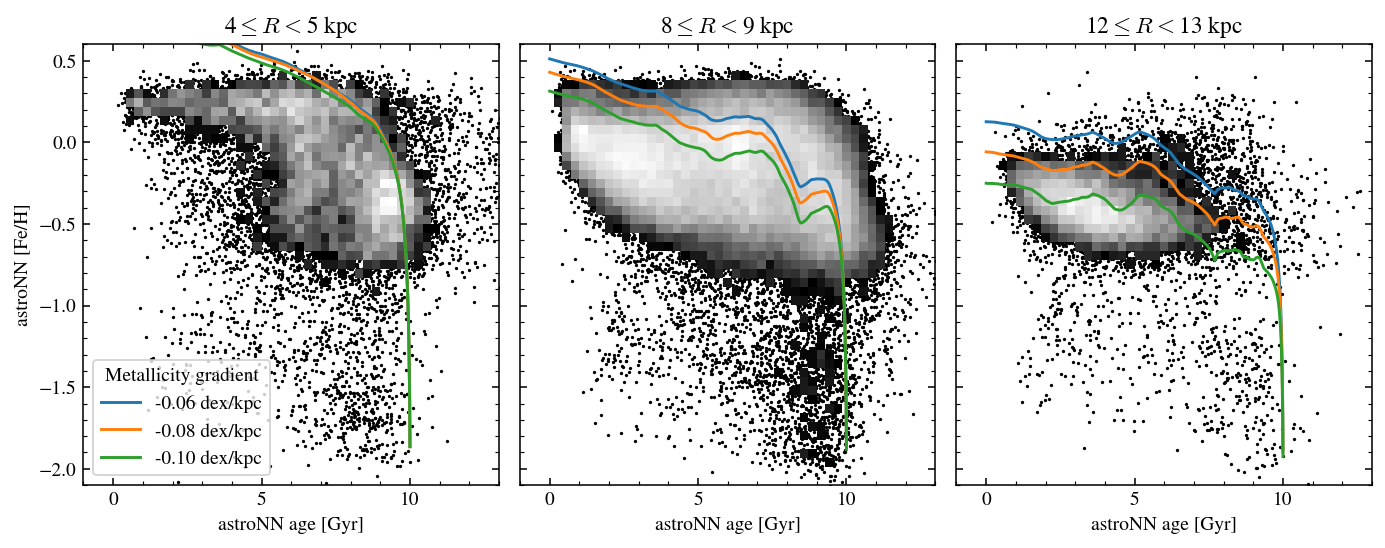

In [9]:
multi_zone_plot(['shallow_eta', 'middling_eta', 'steep_eta'], 'age', 'met', zones=[4, 8, 12], 
                labels=['-0.06 dex/kpc', '-0.08 dex/kpc', '-0.10 dex/kpc'], legend_title='Metallicity gradient')

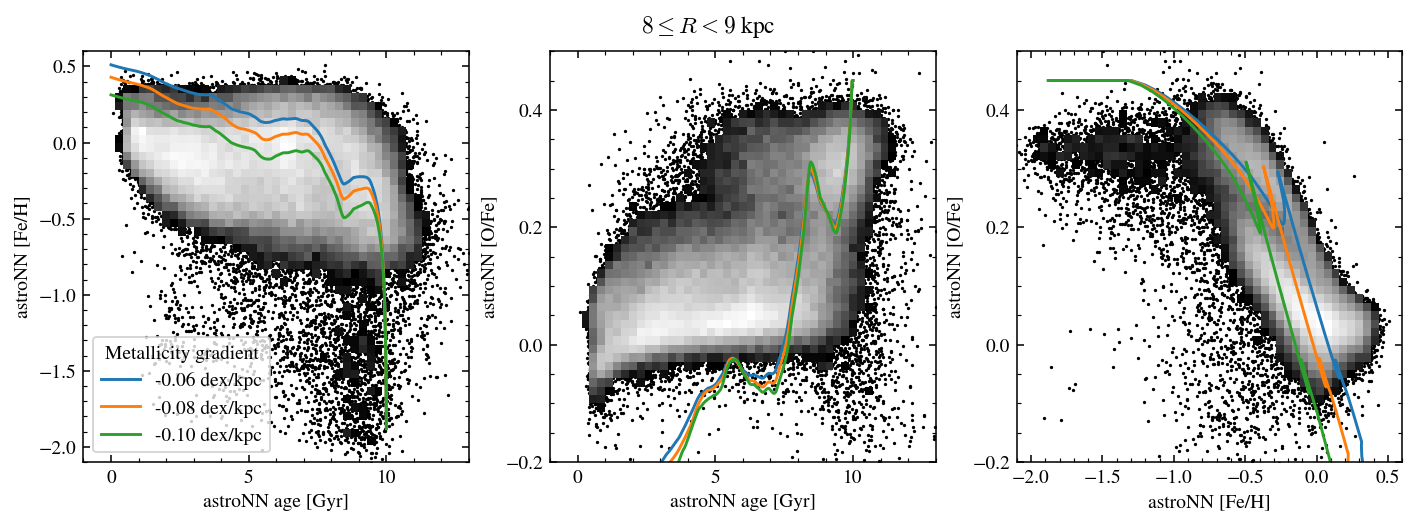

In [12]:
single_zone_plot(['shallow_eta', 'middling_eta', 'steep_eta'], 8, labels=['-0.06 dex/kpc', '-0.08 dex/kpc', '-0.10 dex/kpc'], legend_title='Metallicity gradient')

## Star formation histories

In [70]:
mw = vice.milkyway(name='milkyway/constant_sfh', N=2e5, zone_width=1.0)
mw.migration.stars = hds
mw.delay = 0.04 # Gyr
mw.RIa = 'plaw'
mw.mass_loading = lambda r: eta(r, gradient=-0.08)
mw.mode = 'sfr'
mw.evolution = constant_sfh
mw.dt = 0.01
mw.run(simtime, overwrite=True)

mw = vice.milkyway(name='milkyway/inside_out', N=2e5, zone_width=1.0)
mw.migration.stars = hds
mw.delay = 0.04 # Gyr
mw.RIa = 'plaw'
mw.mass_loading = lambda r: eta(r, gradient=-0.08)
mw.mode = 'sfr'
mw.evolution = inside_out
mw.dt = 0.01
mw.run(simtime, overwrite=True)

mw = vice.milkyway(name='milkyway/late_burst', N=2e5, zone_width=1.0)
mw.migration.stars = hds
mw.delay = 0.04 # Gyr
mw.RIa = 'plaw'
mw.mass_loading = lambda r: eta(r, gradient=-0.08)
mw.mode = 'sfr'
mw.evolution = late_burst
mw.dt = 0.01
mw.run(simtime, overwrite=True)

/home/lodubay/anaconda3/lib/python3.9/site-packages/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: stars
  warnings.warn("""\


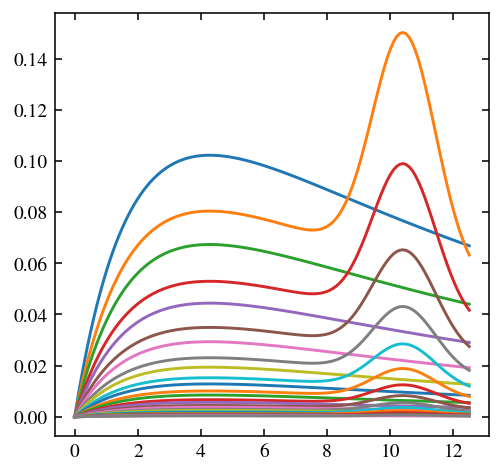

In [69]:
tarr = np.arange(0, 12.6, 0.1)
for r in range(2, 16):
    plt.plot(tarr, A_io * f_io(tarr) * g(r))
    plt.plot(tarr, A_lb * f_lb(tarr) * g(r))
plt.show()

In [62]:
print(A_c)

0.15092708564572174


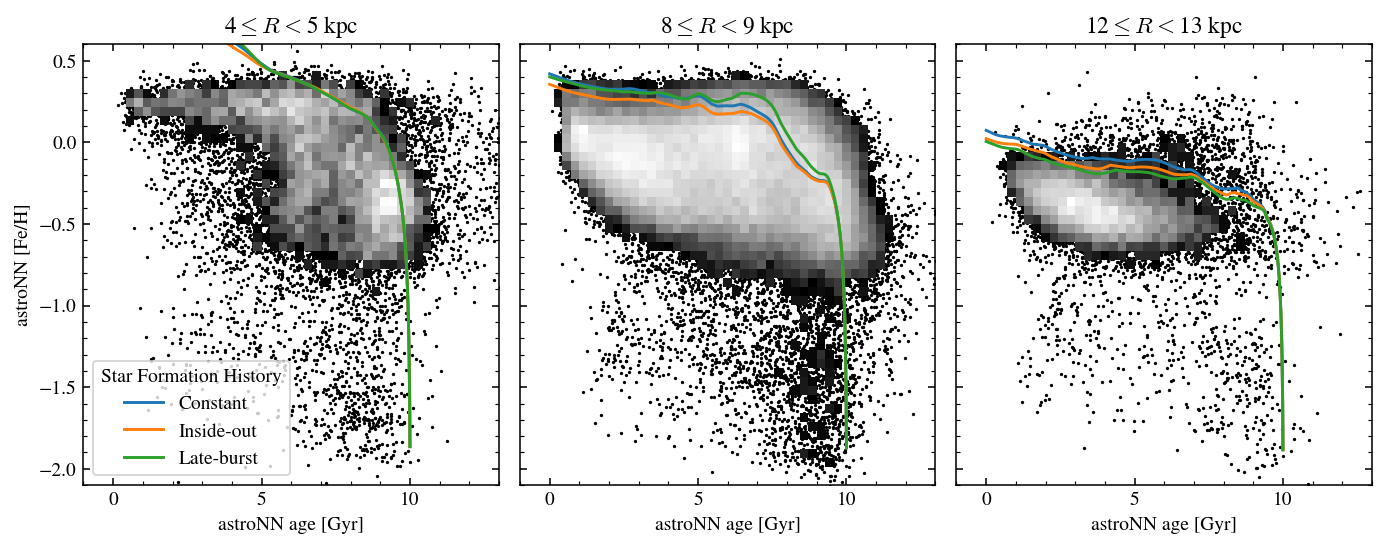

In [71]:
multi_zone_plot(['constant_sfh', 'inside_out', 'late_burst'], 'age', 'met', zones=[4, 8, 12], 
                labels=['Constant', 'Inside-out', 'Late-burst'], legend_title='Star Formation History')

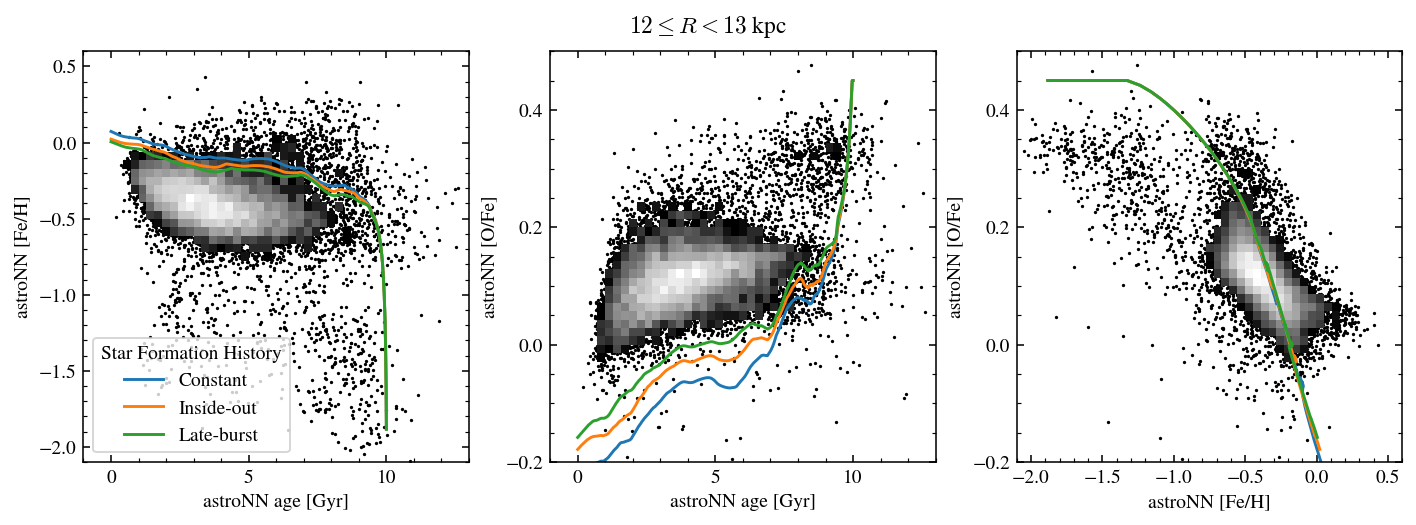

In [72]:
single_zone_plot(['constant_sfh', 'inside_out', 'late_burst'], 12, labels=['Constant', 'Inside-out', 'Late-burst'], legend_title='Star Formation History')

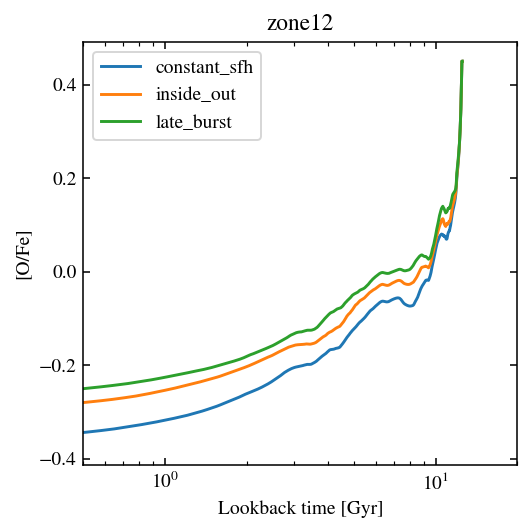

In [17]:
fig, ax = plt.subplots()
zone = 12
vice_names = ['constant_sfh', 'inside_out', 'late_burst']
for vice_name in vice_names:
    out = vice.output('milkyway/' + vice_name)
    vice_hist = out.zones['zone%s' % zone].history
    ax.plot(np.array(vice_hist['lookback']), vice_hist['[o/fe]'], label=vice_name)
ax.set_xscale('log')
ax.set_xlim(0.5, 20)
ax.set_ylabel('[O/Fe]')
ax.set_xlabel('Lookback time [Gyr]')
ax.set_title('zone12')
ax.legend()
plt.show()

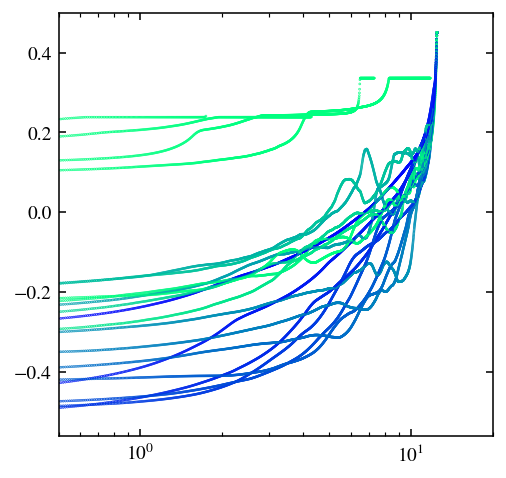

In [76]:
out = vice.output('milkyway/late_burst')
stars = out.stars

fig, ax = plt.subplots()

ZONE_WIDTH = 1
COLORMAP = "winter"
colors = [ZONE_WIDTH * (i + 0.5) for i in stars["zone_origin"]]
sc = ax.scatter(stars["age"], stars["[O/Fe]"], c = colors, s = 0.1,
    cmap = plt.get_cmap(COLORMAP), vmin = 0, vmax = 15, rasterized = True)
ax.set_xscale('log')
ax.set_xlim(0.5, 20)
plt.show()

## Different Ia delay-time distributions

In [34]:
# Fiducial model: default settings, power-law DTD, 40 Myr minimum delay time, shallower metallicity gradient
mw = vice.milkyway(name='milkyway/fiducial', N=2e5, zone_width=1.0)
mw.migration.stars = hds
mw.delay = 0.04 # Gyr
mw.mass_loading = eta
mw.run(simtime, overwrite=True)

/home/dubay.11/.local/lib/python3.8/site-packages/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: stars
  warnings.warn("""\
/home/dubay.11/.local/lib/python3.8/site-packages/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: func
  warnings.warn("""\


In [35]:
# Fiducial model with exponential DTD
mw = vice.milkyway(name='milkyway/exponential', N=2e5, zone_width=1.0)
mw.migration.stars = hds
mw.delay = 0.04 # Gyr
mw.mass_loading = eta
mw.RIa = 'exp'
mw.tau_Ia = 3 # Gyr
mw.run(simtime, overwrite=True)

In [36]:
# Fiducial model with wide gaussian DTD
def gauss(t, sigma=1, center=1):
    return np.exp(-(t-center)**2/(2*sigma**2))

mw = vice.milkyway(name='milkyway/wide_gauss', N=2e5, zone_width=1.0)
mw.migration.stars = hds
mw.delay = 0.04 # Gyr
mw.mass_loading = eta
mw.RIa = lambda t: gauss(t, sigma=2, center=3)
mw.run(simtime, overwrite=True)

In [37]:
# Fiducial + narrow Gaussian
mw = vice.milkyway(name='milkyway/narrow_gauss', N=2e5, zone_width=1.0)
mw.migration.stars = hds
mw.delay = 0.04 # Gyr
mw.mass_loading = eta
mw.RIa = lambda t: gauss(t, sigma=0.2, center=1)
mw.run(simtime, overwrite=True)

In [38]:
# Fiducial + bimodal DTD
def bimodal(t, tau_ia=0.09):
    if t < tau_ia:
        return 10**(1.4 - 50*(np.log10(t*1e9) - 7.7)**2)
    else:
        return 10**(-0.8 - 0.9*(np.log10(t*1e9) - 8.7)**2)

mw = vice.milkyway(name='milkyway/bimodal', N=2e5, zone_width=1.0)
mw.migration.stars = hds
mw.delay = 0.04 # Gyr
mw.mass_loading = eta
mw.RIa = bimodal
mw.run(simtime, overwrite=True)

In [39]:
# Fiducial + uniform DTD
def uniform(t, tmin=0, tmax=1):
    return int(t>=tmin and t<tmax)

mw = vice.milkyway(name='milkyway/uniform', N=2e5, zone_width=1.0)
mw.migration.stars = hds
mw.delay = 0.04 # Gyr
mw.mass_loading = eta
mw.RIa = uniform
mw.run(simtime, overwrite=True)

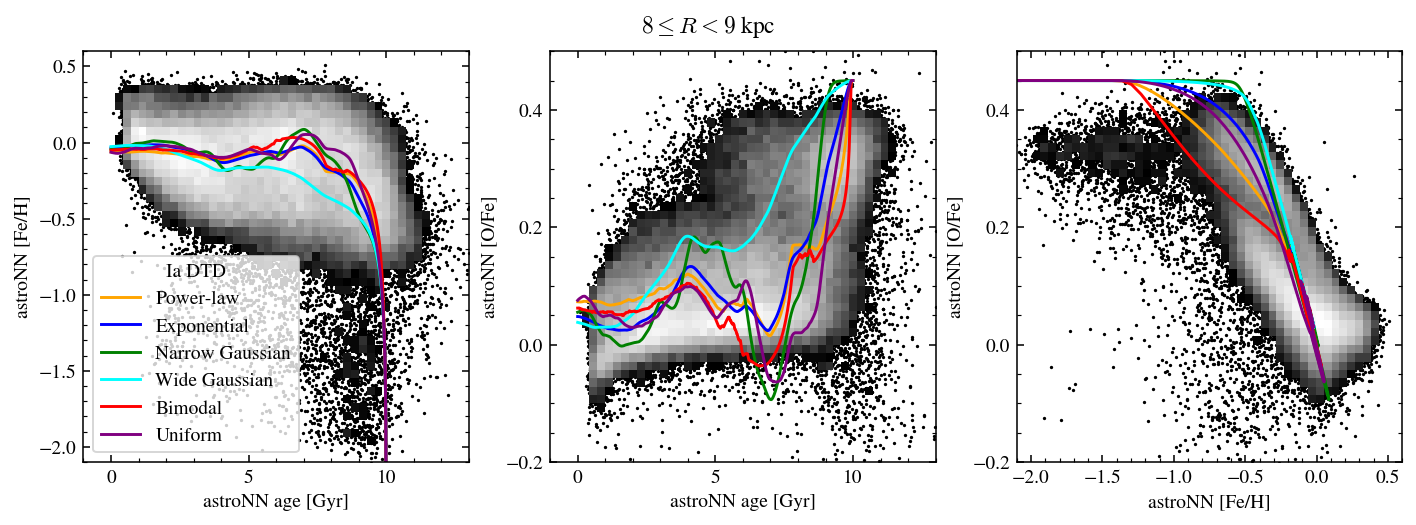

In [19]:
# Plot all DTDs vs data
dtds = ['fiducial', 'exponential', 'narrow_gauss', 'wide_gauss', 'bimodal', 'uniform']
# dtd_labels = ['Power-law (slope=-1.1)', r'Exponential ($\tau_{\rm{Ia}}=3$ Gyr)',
#               r'Narrow Gaussian ($\mu=1$ Gyr, $\sigma=0.2$ Gyr)',
#               r'Wide Gaussian ($\mu=3$ Gyr, $\sigma=2$ Gyr)',
#               r'Bimodal ($\mu_1=0.05$ Gyr, $\mu_2=0.5$ Gyr)',
#               r'Uniform ($t_{\rm{max}}=1$ Gyr)']
dtd_labels = ['Power-law', 'Exponential', 'Narrow Gaussian', 'Wide Gaussian', 'Bimodal', 'Uniform']
colors = ['orange', 'blue', 'green', 'cyan', 'red', 'purple']
single_zone_plot(dtds, 8, labels=dtd_labels, fmt=colors, legend_title='Ia DTD', save='triplot_dtd_8kpc.png')

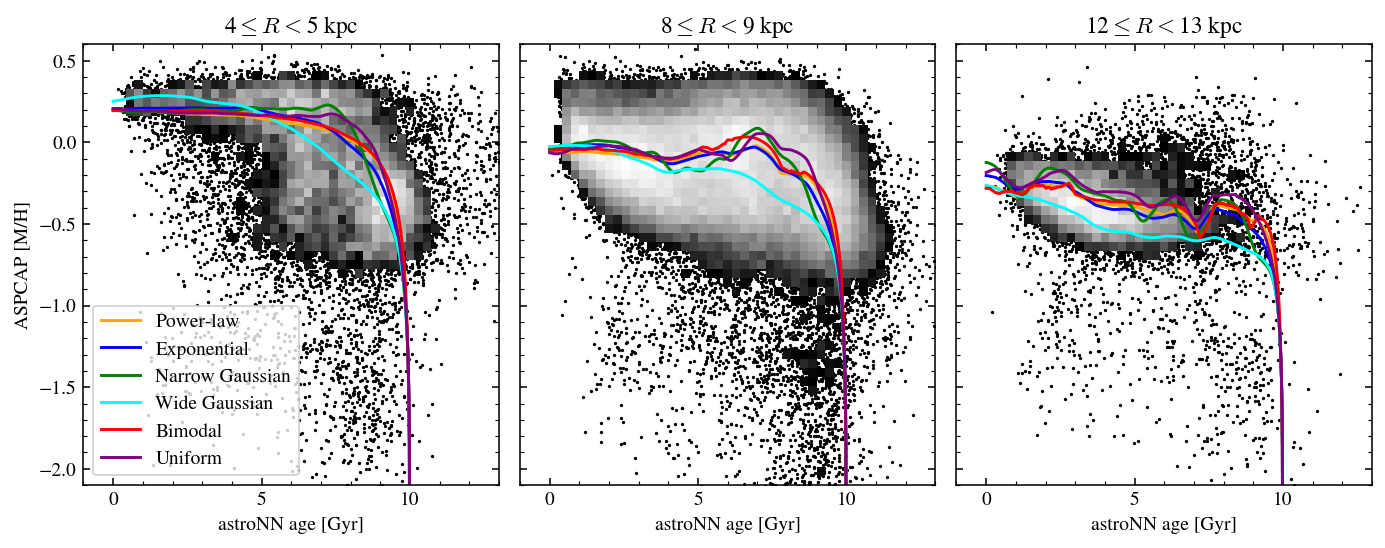

In [60]:
multi_zone_plot(dtds, 'age', 'met', zones=[4, 8, 12], labels=dtd_labels, fmt=colors, data_source='ASPCAP')

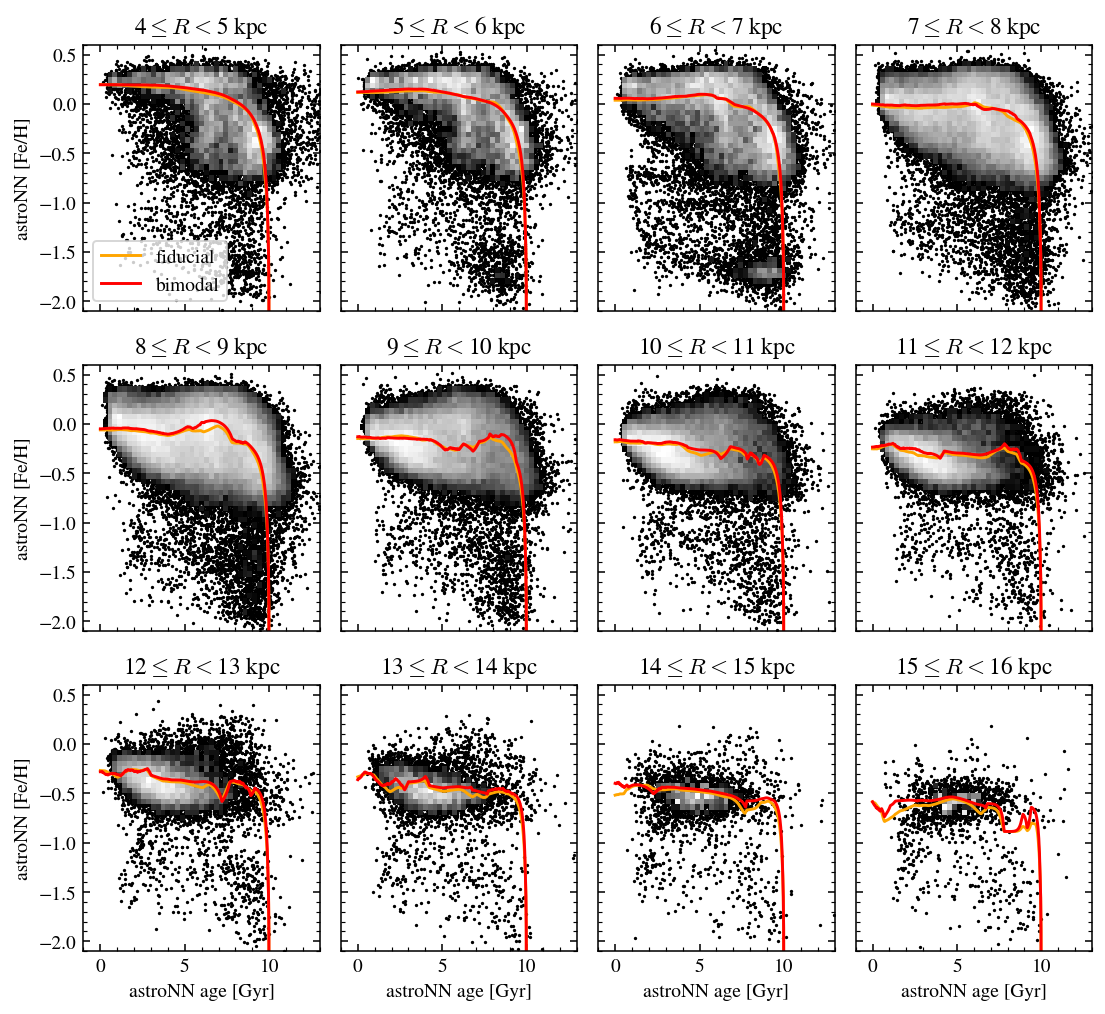

In [75]:
multi_zone_plot(['fiducial', 'bimodal'], 'age', 'met', zones=list(np.linspace(4, 15, 12).astype('int')), fmt=['orange', 'red'], data_source='astroNN', nrows=3, width=8)

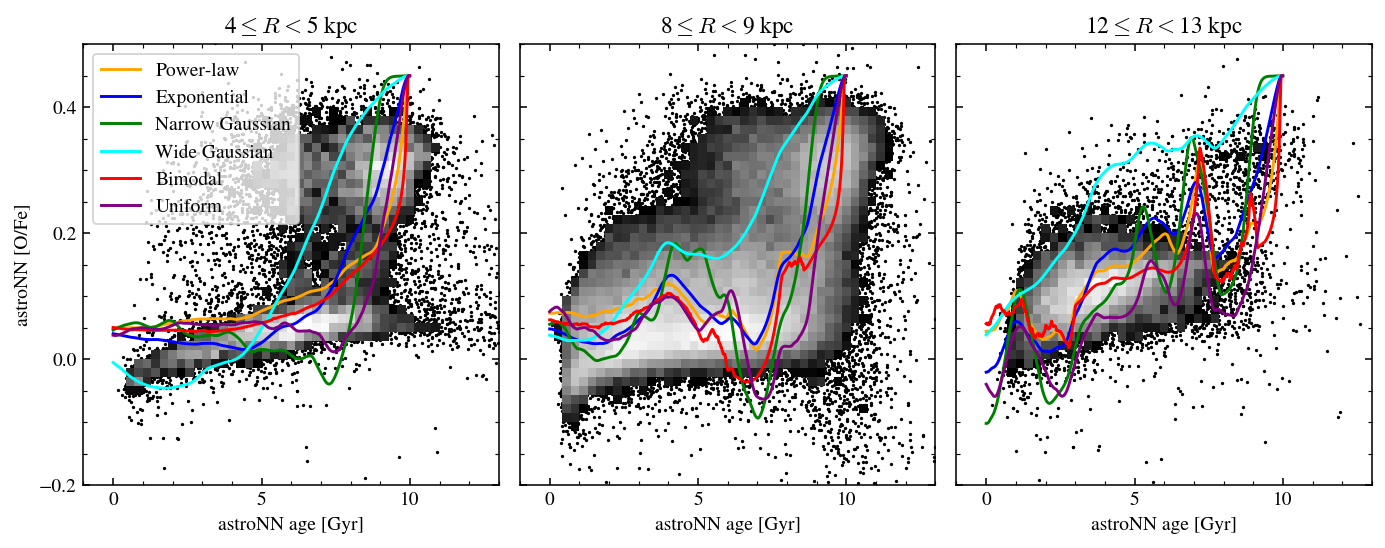

In [74]:
multi_zone_plot(dtds, 'age', 'alpha', zones=[4, 8, 12], labels=dtd_labels, fmt=colors)

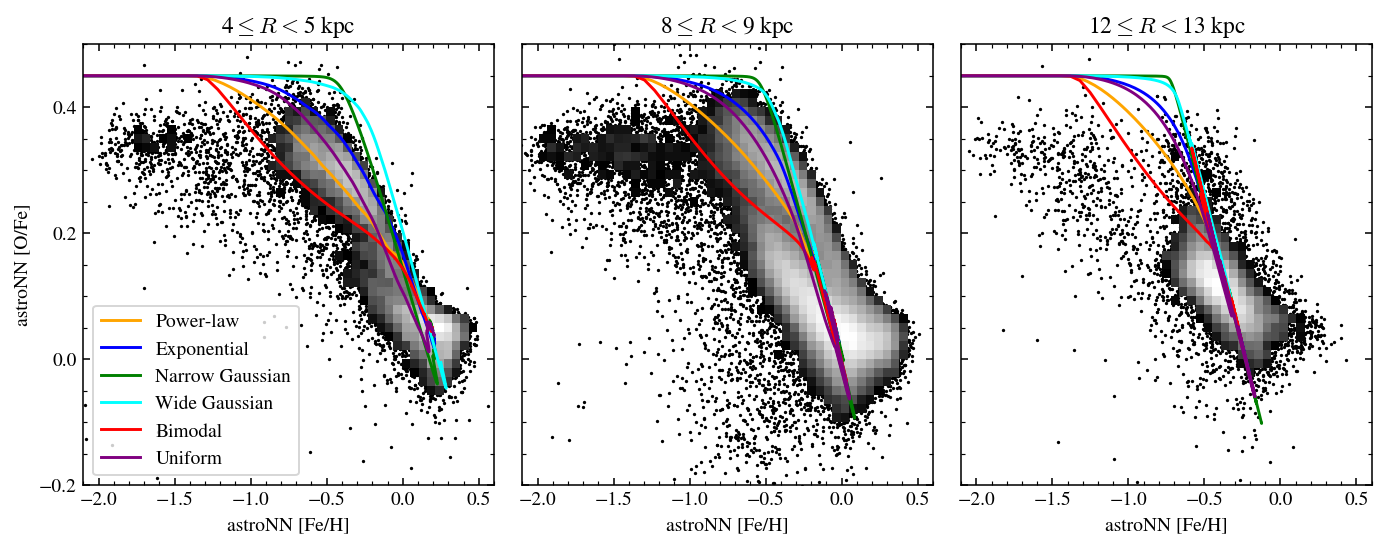

In [76]:
multi_zone_plot(dtds, 'met', 'alpha', zones=[4, 8, 12], labels=dtd_labels, fmt=colors)

## Infall rates (old)

In [40]:
# Power-law DTD with different infall rates

mw = vice.milkyway(name='milkyway/low_ifr', N=2e5, zone_width=1.0)
mw.migration.stars = hds
mw.delay = 0.04 # Gyr
mw.RIa = 'plaw'
mw.evolution = lambda r, t: 0.5
mw.mode = 'ifr'
mw.run(simtime, overwrite=True)

mw = vice.milkyway(name='milkyway/high_ifr', N=2e5, zone_width=1.0)
mw.migration.stars = hds
mw.delay = 0.04 # Gyr
mw.RIa = 'plaw'
mw.evolution = lambda r, t: 2.
mw.mode = 'ifr'
mw.run(simtime, overwrite=True)

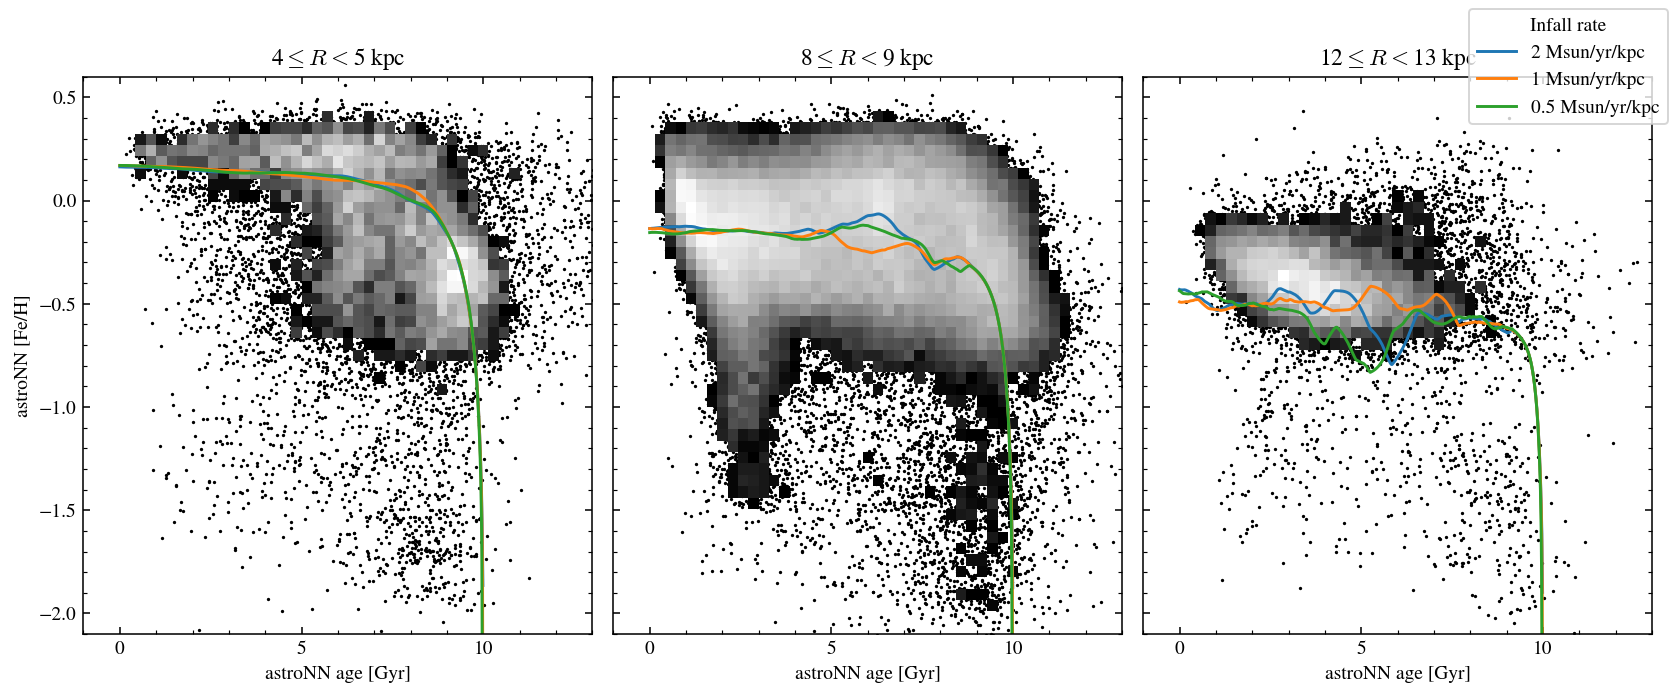

In [49]:
multi_zone_plot(['high_ifr', 'fiducial', 'low_ifr'], 'age', 'met', zones=[4, 8, 12], labels=['2 Msun/yr/kpc', '1 Msun/yr/kpc', '0.5 Msun/yr/kpc'], legend_title='Infall rate')

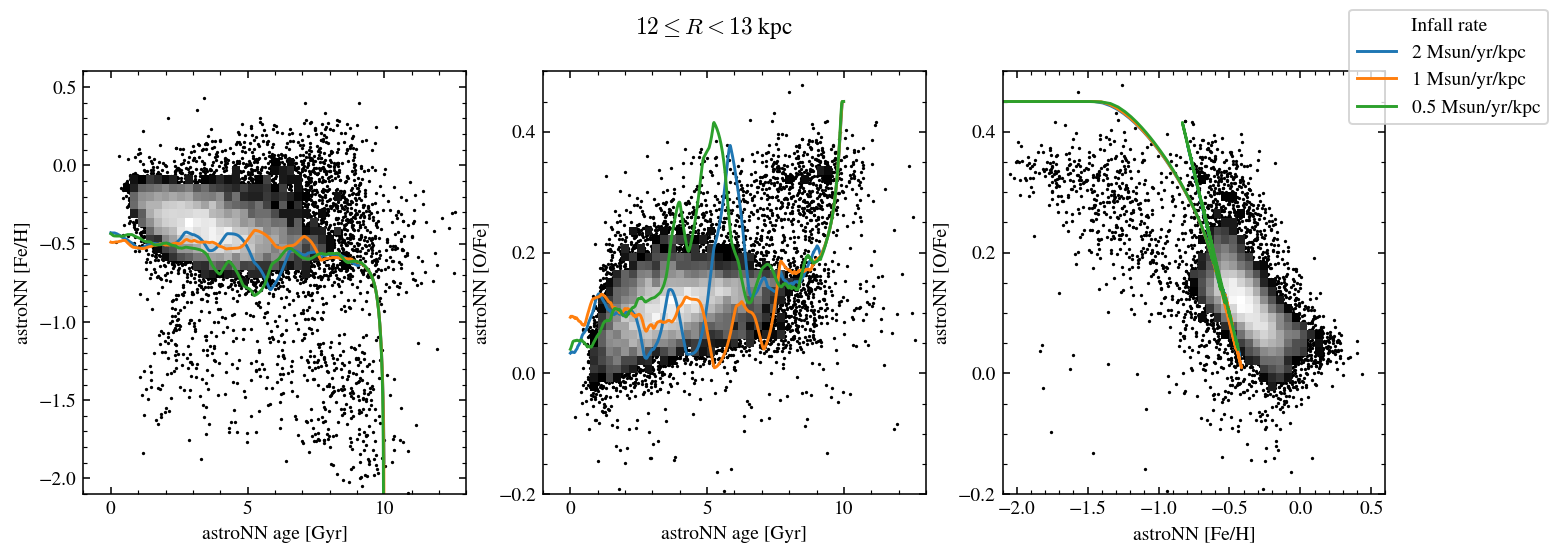

In [50]:
single_zone_plot(['high_ifr', 'fiducial', 'low_ifr'], 12, labels=['2 Msun/yr/kpc', '1 Msun/yr/kpc', '0.5 Msun/yr/kpc'], legend_title='Infall rate')

[]

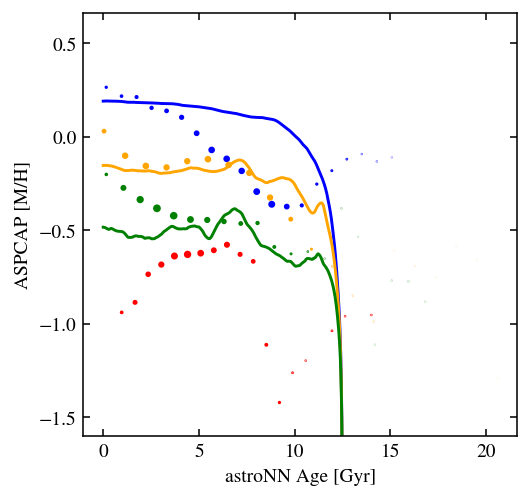

In [32]:
mw_out = vice.multioutput('milkyway/fiducial')

fig, ax = plt.subplots()

colors = ['b', 'orange', 'g', 'r', 'k']
for i, z in enumerate([4, 8, 12, 16]):
    data_zone = data[(data['ASTRONN_GALR'] >= z) & (data['ASTRONN_GALR'] < z+1)][['ASTRONN_AGE', 'M_H']]
    # Bin by age
    ages, age_bins = pd.cut(data_zone['ASTRONN_AGE'], 20, retbins=True)
    # Median [M/H] for each age bin
    median = data_zone['M_H'].groupby(ages).median()
    frac = data_zone['M_H'].groupby(ages).count() / data_zone.shape[0]
    # Plot median [M/H]
    ax.scatter(age_bins[:-1], median, marker='o', s=frac*50, color=colors[i])
    
    # Import VICE zone
    vice_zone = mw.zones[z]
    vice_hist = mw_out.zones[vice_zone.name].history
    ax.plot(np.array(vice_hist['lookback']), vice_hist['[fe/h]'], color=colors[i])

ax.set_ylim((-1.6, None))
ax.set_xlabel('astroNN Age [Gyr]')
ax.set_ylabel('ASPCAP [M/H]')
plt.plot()